# Project_Notes_012

## Forecasting Renewable Energy Generation Reload
In this project, the data of Project_Notes_011 will be analysed using deep learing with the obtained result compared with the essemble and xgb results.

In [1]:
# Import required modules.
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

In [4]:
# load the saved file.
df = pd.read_parquet('./data/Project_Notes_011_renewable_data.parquet')

In [5]:
# Subset categorical and numerical columns
num_features = df.select_dtypes(include="number").columns.to_list()
cat_features = df.select_dtypes(exclude="number").columns.to_list()

In [6]:
# Create masks for the cat_features columns.
mask_traffic = {'Low': 1, 'Moderate': 2, 'High': 3}
mask_preference = {'Morning': 1, 'Afternoon': 2, 'Evening': 3}
mask_others = {'Low': 1, 'Mid': 2, 'High': 3, 'Unknown': 3}

In [7]:
# Create a function to apply the masks.
def mask_unique(df):
    df['traffic'] = df['traffic'].map(mask_traffic)
    df['preference'] = df['preference'].map(mask_preference)
    df['fog'] = df['fog'].map(mask_others)
    df['rain'] = df['rain'].map(mask_others)
    df['snow'] = df['snow'].map(mask_others)
    df['hail'] = df['hail'].map(mask_others)
    return df

In [8]:
# Apply the mask function.
df = mask_unique(df)

In [9]:
# Prepare X the features and y the target.
X = df.copy()
y = X.pop('delivery')

In [10]:
# Apply scaler to X and y.
scalar_X, scalar_y = MinMaxScaler(), MinMaxScaler()
scalar_X.fit(X)
scalar_y.fit(np.array(y).reshape(-1, 1))
X = scalar_X.transform(X)
y = scalar_y.transform(np.array(y).reshape(-1, 1))

In [11]:
# Split the data.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define the input shape.
input_shape = [X.shape[1]]
input_shape

[13]

In [13]:
# Create the model.
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

In [14]:
# Add Loss and Optimizer.
model.compile(
    optimizer='adam',
    loss='mae',
)

In [15]:
# Train the model.
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100
)

Epoch 1/100

202/202 [==============================] - 2s 5ms/step - loss: 0.1125 - val_loss: 0.0981
Epoch 2/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0968 - val_loss: 0.0960
Epoch 3/100
202/202 [==============================] - 1s 5ms/step - loss: 0.0952 - val_loss: 0.0946
Epoch 4/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0945 - val_loss: 0.0942
Epoch 5/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0944 - val_loss: 0.0945
Epoch 6/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0942 - val_loss: 0.0936
Epoch 7/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0936 - val_loss: 0.0935
Epoch 8/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0935 - val_loss: 0.0933
Epoch 9/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0930 - val_loss: 0.0934
Epoch 10/100
202/202 [==============================] - 1s 4ms/step - loss: 0.0931 - val_l

Minimum Validation Loss: 0.0922
Minimum Validation index: 59


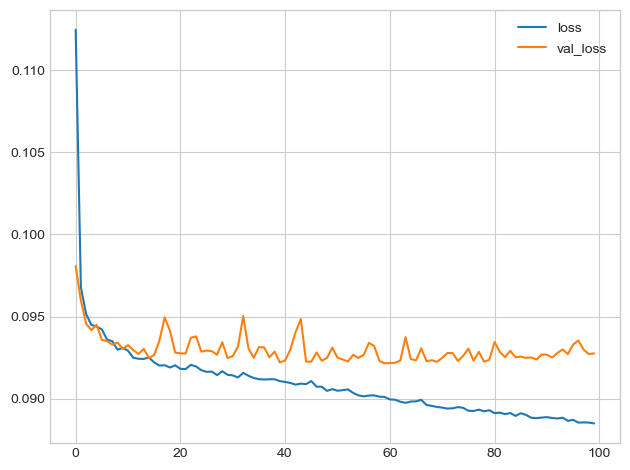

In [16]:
# Plot the loss against the val_loss.
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(f"Minimum Validation Loss: {history_df['val_loss'].min():0.4f}")
print(f"Minimum Validation index: {history_df[history_df['val_loss'] == history_df['val_loss'].min()].index[0]}")

In [17]:
# Create function to predict the raw data
def predict_data(raw_data):
    data_frame = pd.DataFrame(raw_data, index=[0])
    data_scale = scalar_X.transform(data_frame )
    data_predict = model.predict(data_scale)[0][0]
    data_inverse = scalar_y.inverse_transform(np.array(data_predict).reshape(-1, 1))[0][0]
    return data_inverse

In [18]:
# Get the sample data to use.
sample_data = df.loc[22]
sample_data

traffic          1.000000
packages         7.000000
preference       2.000000
distance       134.105783
fog              2.000000
rain             1.000000
snow             2.000000
hail             3.000000
year          2023.000000
month            4.000000
day             17.000000
hour            10.000000
minute          15.000000
delivery         7.665117
Name: 22, dtype: float64

In [20]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 7.0,
 'preference': 2.0,
 'distance': 134.10578342021049,
 'fog': 2.0,
 'rain': 1.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2023.0,
 'month': 4.0,
 'day': 17.0,
 'hour': 10.0,
 'minute': 15.0}

In [21]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 216ms/step


7.6658254

In [22]:
# Get the sample data to use.
sample_data = df.loc[199]
sample_data

traffic          1.000000
packages         1.000000
preference       2.000000
distance       120.157517
fog              3.000000
rain             3.000000
snow             2.000000
hail             3.000000
year          2020.000000
month            8.000000
day              6.000000
hour            10.000000
minute          29.000000
delivery         5.867858
Name: 199, dtype: float64

In [23]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 1.0,
 'preference': 2.0,
 'distance': 120.15751736289026,
 'fog': 3.0,
 'rain': 3.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2020.0,
 'month': 8.0,
 'day': 6.0,
 'hour': 10.0,
 'minute': 29.0}

In [24]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 24ms/step


5.441031

In [25]:
# Get the sample data to use.
sample_data = df.loc[303]
sample_data

traffic          3.000000
packages        20.000000
preference       3.000000
distance       171.415035
fog              1.000000
rain             1.000000
snow             1.000000
hail             1.000000
year          2021.000000
month            7.000000
day              2.000000
hour             8.000000
minute           6.000000
delivery        14.218450
Name: 303, dtype: float64

In [26]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 3.0,
 'packages': 20.0,
 'preference': 3.0,
 'distance': 171.41503459195576,
 'fog': 1.0,
 'rain': 1.0,
 'snow': 1.0,
 'hail': 1.0,
 'year': 2021.0,
 'month': 7.0,
 'day': 2.0,
 'hour': 8.0,
 'minute': 6.0}

In [27]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 47ms/step


12.341938

### Define Early Stopping Callback

Minimum Validation Loss: 0.0928
Minimum Validation index: 20


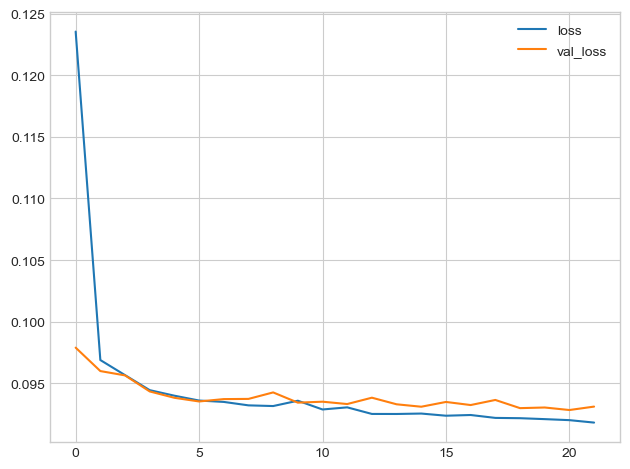

In [28]:
# Define an early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Create the model.
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])

# Add Loss and Optimizer.
model.compile(
    optimizer='adam',
    loss='mae'
)

# Split the data.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model.
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    verbose=0,    
    callbacks=[early_stopping]
)

# Plot the history.
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print(f"Minimum Validation Loss: {history_df['val_loss'].min():0.4f}")
print(f"Minimum Validation index: {history_df[history_df['val_loss'] == history_df['val_loss'].min()].index[0]}")

In [29]:
# Get the sample data to use.
sample_data = df.loc[22]
sample_data

traffic          1.000000
packages         7.000000
preference       2.000000
distance       134.105783
fog              2.000000
rain             1.000000
snow             2.000000
hail             3.000000
year          2023.000000
month            4.000000
day             17.000000
hour            10.000000
minute          15.000000
delivery         7.665117
Name: 22, dtype: float64

In [30]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 7.0,
 'preference': 2.0,
 'distance': 134.10578342021049,
 'fog': 2.0,
 'rain': 1.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2023.0,
 'month': 4.0,
 'day': 17.0,
 'hour': 10.0,
 'minute': 15.0}

In [31]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 125ms/step


7.571627

In [32]:
# Get the sample data to use.
sample_data = df.loc[199]
sample_data

traffic          1.000000
packages         1.000000
preference       2.000000
distance       120.157517
fog              3.000000
rain             3.000000
snow             2.000000
hail             3.000000
year          2020.000000
month            8.000000
day              6.000000
hour            10.000000
minute          29.000000
delivery         5.867858
Name: 199, dtype: float64

In [33]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 1.0,
 'preference': 2.0,
 'distance': 120.15751736289026,
 'fog': 3.0,
 'rain': 3.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2020.0,
 'month': 8.0,
 'day': 6.0,
 'hour': 10.0,
 'minute': 29.0}

In [34]:
# Compute prediction
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 16ms/step


5.0638065

In [35]:
# Get the sample data to use.
sample_data = df.loc[303]
sample_data

traffic          3.000000
packages        20.000000
preference       3.000000
distance       171.415035
fog              1.000000
rain             1.000000
snow             1.000000
hail             1.000000
year          2021.000000
month            7.000000
day              2.000000
hour             8.000000
minute           6.000000
delivery        14.218450
Name: 303, dtype: float64

In [36]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 3.0,
 'packages': 20.0,
 'preference': 3.0,
 'distance': 171.41503459195576,
 'fog': 1.0,
 'rain': 1.0,
 'snow': 1.0,
 'hail': 1.0,
 'year': 2021.0,
 'month': 7.0,
 'day': 2.0,
 'hour': 8.0,
 'minute': 6.0}

In [37]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 32ms/step


12.658952

### Dropout and Batch Normalization

Minimum Validation Loss: 0.0924
Minimum Validation index: 95


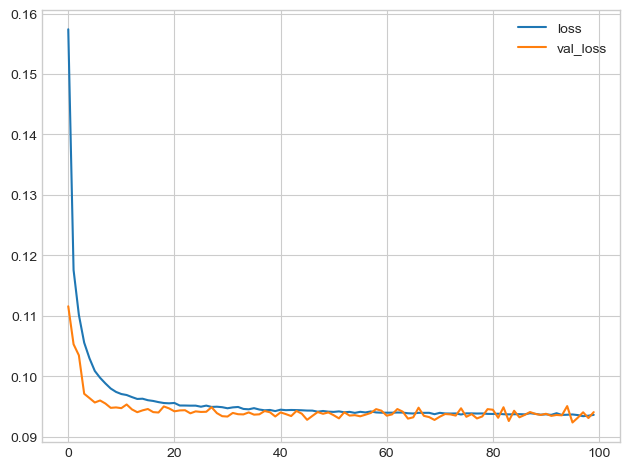

In [38]:
# Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1)
])

# Add Loss and Optimizer.
model.compile(
    optimizer='adam',
    loss='mae',
)

# Train the model.
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    verbose=0
)

# Plot the history.
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print(f"Minimum Validation Loss: {history_df['val_loss'].min():0.4f}")
print(f"Minimum Validation index: {history_df[history_df['val_loss'] == history_df['val_loss'].min()].index[0]}")

In [39]:
# Get the sample data to use.
sample_data = df.loc[22]
sample_data

traffic          1.000000
packages         7.000000
preference       2.000000
distance       134.105783
fog              2.000000
rain             1.000000
snow             2.000000
hail             3.000000
year          2023.000000
month            4.000000
day             17.000000
hour            10.000000
minute          15.000000
delivery         7.665117
Name: 22, dtype: float64

In [40]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 7.0,
 'preference': 2.0,
 'distance': 134.10578342021049,
 'fog': 2.0,
 'rain': 1.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2023.0,
 'month': 4.0,
 'day': 17.0,
 'hour': 10.0,
 'minute': 15.0}

In [41]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 94ms/step


7.5437083

In [42]:
# Get the sample data to use.
sample_data = df.loc[199]
sample_data

traffic          1.000000
packages         1.000000
preference       2.000000
distance       120.157517
fog              3.000000
rain             3.000000
snow             2.000000
hail             3.000000
year          2020.000000
month            8.000000
day              6.000000
hour            10.000000
minute          29.000000
delivery         5.867858
Name: 199, dtype: float64

In [43]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 1.0,
 'preference': 2.0,
 'distance': 120.15751736289026,
 'fog': 3.0,
 'rain': 3.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2020.0,
 'month': 8.0,
 'day': 6.0,
 'hour': 10.0,
 'minute': 29.0}

In [44]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 39ms/step


5.6716375

In [45]:
# Get the sample data to use.
sample_data = df.loc[303]
sample_data

traffic          3.000000
packages        20.000000
preference       3.000000
distance       171.415035
fog              1.000000
rain             1.000000
snow             1.000000
hail             1.000000
year          2021.000000
month            7.000000
day              2.000000
hour             8.000000
minute           6.000000
delivery        14.218450
Name: 303, dtype: float64

In [46]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 3.0,
 'packages': 20.0,
 'preference': 3.0,
 'distance': 171.41503459195576,
 'fog': 1.0,
 'rain': 1.0,
 'snow': 1.0,
 'hail': 1.0,
 'year': 2021.0,
 'month': 7.0,
 'day': 2.0,
 'hour': 8.0,
 'minute': 6.0}

In [47]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 55ms/step


11.840632

### Add Batch Normalization Layers


Minimum Validation Loss: 0.1136
Minimum Validation index: 87


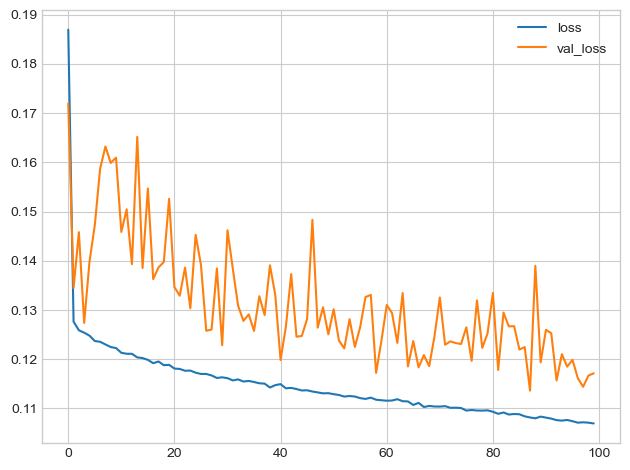

In [48]:
# Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

# Add Loss and Optimizer.
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)

# Define epochs.
EPOCHS = 100

# Train the model.
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0
)

# Plot the history.
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print(f"Minimum Validation Loss: {history_df['val_loss'].min():0.4f}")
print(f"Minimum Validation index: {history_df[history_df['val_loss'] == history_df['val_loss'].min()].index[0]}")

In [49]:
# Get the sample data to use.
sample_data = df.loc[22]
sample_data

traffic          1.000000
packages         7.000000
preference       2.000000
distance       134.105783
fog              2.000000
rain             1.000000
snow             2.000000
hail             3.000000
year          2023.000000
month            4.000000
day             17.000000
hour            10.000000
minute          15.000000
delivery         7.665117
Name: 22, dtype: float64

In [50]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 7.0,
 'preference': 2.0,
 'distance': 134.10578342021049,
 'fog': 2.0,
 'rain': 1.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2023.0,
 'month': 4.0,
 'day': 17.0,
 'hour': 10.0,
 'minute': 15.0}

In [51]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 242ms/step


7.911981

In [52]:
# Get the sample data to use.
sample_data = df.loc[199]
sample_data

traffic          1.000000
packages         1.000000
preference       2.000000
distance       120.157517
fog              3.000000
rain             3.000000
snow             2.000000
hail             3.000000
year          2020.000000
month            8.000000
day              6.000000
hour            10.000000
minute          29.000000
delivery         5.867858
Name: 199, dtype: float64

In [53]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 1.0,
 'packages': 1.0,
 'preference': 2.0,
 'distance': 120.15751736289026,
 'fog': 3.0,
 'rain': 3.0,
 'snow': 2.0,
 'hail': 3.0,
 'year': 2020.0,
 'month': 8.0,
 'day': 6.0,
 'hour': 10.0,
 'minute': 29.0}

In [54]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 60ms/step


4.4832397

In [55]:
# Get the sample data to use.
sample_data = df.loc[303]
sample_data

traffic          3.000000
packages        20.000000
preference       3.000000
distance       171.415035
fog              1.000000
rain             1.000000
snow             1.000000
hail             1.000000
year          2021.000000
month            7.000000
day              2.000000
hour             8.000000
minute           6.000000
delivery        14.218450
Name: 303, dtype: float64

In [56]:
# Extract raw data.
raw_data = {
    'traffic': sample_data.loc['traffic'],
    'packages': sample_data.loc['packages'],
    'preference': sample_data.loc['preference'],
    'distance': sample_data.loc['distance'],
    'fog': sample_data.loc['fog'],
    'rain': sample_data.loc['rain'],
    'snow': sample_data.loc['snow'],
    'hail': sample_data.loc['hail'],
    'year': sample_data.loc['year'],
    'month': sample_data.loc['month'],
    'day': sample_data.loc['day'],
    'hour': sample_data.loc['hour'],
    'minute': sample_data.loc['minute']
}

raw_data

{'traffic': 3.0,
 'packages': 20.0,
 'preference': 3.0,
 'distance': 171.41503459195576,
 'fog': 1.0,
 'rain': 1.0,
 'snow': 1.0,
 'hail': 1.0,
 'year': 2021.0,
 'month': 7.0,
 'day': 2.0,
 'hour': 8.0,
 'minute': 6.0}

In [57]:
# Compute prediction.
prediction = predict_data(raw_data)
prediction

1/1 [==============================] - 0s 31ms/step


13.851521